# Gaussian Process Regression

This notebook, I will go over how we can implement the Gaussian process (GP) regression algorithm using Jax. This isn't a new algorithm or anything but I would like to get accustomed to using Jax because it will be useful later when I implement the GPs to handle uncertain inputs.

**Inspirations**

* [Github Code](https://github.com/lucasrm25/Structured-Learning-for-Robot-Control/blob/master/GP/jaxGP.py) - [Lucas](https://www.linkedin.com/in/lucas-rath/?originalSubdomain=bo)
> Broke down the GP function very nicely. Nice enough for me to follow.
* [Scikit-Learn](https://github.com/scikit-learn/scikit-learn/blob/95d4f0841/sklearn/gaussian_process/_gpr.py#L22)
> Good thorough implementation. Does a lot of nice tricks to optimize the code. They don't use automatic differentiation
* [Jax Example](https://github.com/google/jax/blob/master/examples/gaussian_process_regression.py)
> A nice concise implementation that actually works with Jax. It gave me hope when I was coding mine up and consistently failing...
* [Numpyro Implementation](http://pyro.ai/numpyro/examples/gp.html)
> Uses MCMC instead of the traditional likelihood. This will be my next project.

## Imports

In [ ]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers
import numpy as np
import numpy as onp

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


# Plotting libraries
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper'])

## Data

In [ ]:
def get_data(N=30, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    Y += sigma_obs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = jnp.linspace(-1.2, 1.2, N_test)

    return X[:, None], Y[:, None], X_test[:, None], None

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(30, 1) (30, 1)


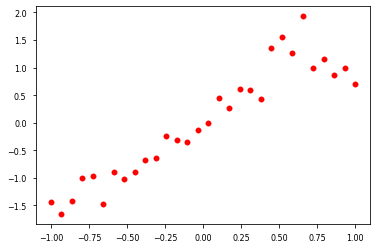

In [ ]:
logger.setLevel(logging.INFO)
X, y, Xtest, ytest = get_data()

fig, ax = plt.subplots()
ax.scatter(X, y, c='red')
plt.show()

## Gaussian Process

## Model: GP Prior

**Parameters**:

* X, Y, $\theta= $ (Likelihood Parameters, Kernel Parameters)

1. Compute the Kernel Matrix
2. Compute the Mean function
3. Sample from the Multivariate Normal Distribution

### Kernel Function

$$k(x,y) = \sigma_f \exp \left( - \frac{1}{2\sigma_\lambda^2}|| x - y||^2_2 \right)$$

In [ ]:
# Squared Euclidean Distance Formula
@jax.jit
def sqeuclidean_distance(x: jnp.array, y: jnp.array) -> float:
    return jnp.sum((x-y)**2)

# RBF Kernel
@jax.jit
def rbf_kernel(params, x, y):
    return jnp.exp( - params['gamma'] * sqeuclidean_distance(x, y))

# ARD Kernel
@jax.jit
def ard_kernel(params, x, y):
    
    # divide by the length scale
    x = x / params['length_scale']
    y = y / params['length_scale']
    
    # return the ard kernel
    return params['var_f'] * jnp.exp( - sqeuclidean_distance(x, y) )

### Kernel Matrix

In [ ]:
# Gram Matrix
def gram(func, params, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(params, x1, y1))(y))(x)

In [ ]:
params = {
    'gamma': 1.0,
    # 'var_f': 1.0,
    'likelihood_noise': 0.01,
}
# input vector
# x_plot = jnp.linspace(X.min(), X.max(), 100)[:, None]
# test_X = x_plot[0, :]


cov_f = functools.partial(gram, rbf_kernel)
K_ = cov_f(params, Xtest, X)
print(K_.shape)

K_ = cov_f(params, X, Xtest)
print(K_.shape)

(400, 30)
(30, 400)


### Mean Function

Honestly, I never work with mean functions. I always assume a zero-mean function and that's it. I don't really know anyone who works with mean functions either. I've seen it used in deep Gaussian processes but I have no expertise in which mean functions to use. So, we'll follow the community standard for now: zero mean function

In [ ]:
def zero_mean(x):
    return jnp.zeros(x.shape[0])

### 3. Compute Model

Now we have all of the components to make our GP prior function.

In [ ]:
def gp_prior(params, mu_f, cov_f, x):
    return mu_f(x) , cov_f(params, x, x)

#### Sampling from the GP Prior

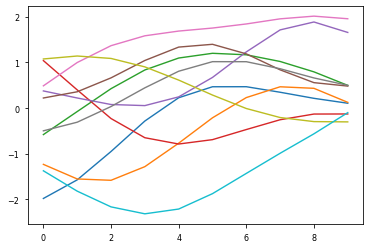

In [ ]:
# checks - 1 vector (D)
params = {
    'gamma': 10., 
    'length_scale': 1e-3, 
}

n_samples = 10                   # condition on 3 samples 
test_X = X[:n_samples, :].copy() # random samples from distribution

mu_f = zero_mean
cov_f = functools.partial(gram, rbf_kernel)
mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f , x=test_X)

# make it semi-positive definite with jitter
jitter = 1e-6
cov_x_ = cov_x + jitter * jnp.eye(cov_x.shape[0])


n_functions = 10                # number of random functions to draw

key = jax.random.PRNGKey(0)

y_samples = jax.random.multivariate_normal(key, mu_x, cov_x_, shape=(n_functions,))

# check
assert y_samples.shape == (n_functions, n_samples)

for isample in y_samples:
    plt.plot(isample)

**Note**:

Sometimes I get a 'positive semi-definite error'. It's due to the diagonals being off. Normally we add something called jitter. This allows the matrix to be positive semi-definite. In this case we don't have that message. This is a small thing but it's super important and can lead to errors in the optimization if not addressed.

## 4. Posterior

Conditioned on the observations, can we make predictions.

In [ ]:
def gp_prior(params, mu_f, cov_f, x):
    return mu_f(x) , cov_f(params, x, x)


def cholesky_factorization(K, Y):

    # cho factor the cholesky
    L = jax.scipy.linalg.cho_factor(K, lower=True)

    # weights
    weights = jax.scipy.linalg.cho_solve(L, Y)

    return L, weights

jitter = 1e-6

def posterior(params, prior_params, X, Y, X_new, likelihood_noise=False, return_cov=False):
    (mu_func, cov_func) = prior_params

    # ==========================
    # 1. GP PRIOR
    # ==========================
    mu_x, Kxx = gp_prior(params, mu_f=mu_func, cov_f=cov_func, x=X)

    # ===========================
    # 2. CHOLESKY FACTORIZATION
    # ===========================
    logging.debug(f"CHOL: Y: {Y.shape}, {mu_func(X).shape}")
    (L, lower), alpha = cholesky_factorization(
        Kxx + (params["likelihood_noise"] + 1e-7) * jnp.eye(Kxx.shape[0]), 
        Y-mu_func(X).reshape(-1,1)
    )

    # ================================
    # 4. PREDICTIVE MEAN DISTRIBUTION
    # ================================

    # calculate transform kernel
    KxX = cov_func(params, X_new, X)

    # Calculate the Mean
    mu_y = jnp.dot(KxX, alpha)

    # =====================================
    # 5. PREDICTIVE COVARIANCE DISTRIBUTION
    # =====================================
    v = jax.scipy.linalg.cho_solve((L, lower), KxX.T)
    
    # Calculate kernel matrix for inputs
    Kxx = cov_func(params, X_new, X_new)
    
    cov_y = Kxx - jnp.dot(KxX, v)

    # Likelihood Noise
    if likelihood_noise is True:
        cov_y += params['likelihood_noise']

    # return variance (diagonals of covaraince)
    if return_cov is not True:
        cov_y = jnp.diag(cov_y)

    return mu_y, cov_y

In [ ]:
logger.setLevel(logging.INFO)
# MEAN FUNCTION
mu_f = zero_mean

# COVARIANCE FUNCTION
params = {
    'gamma': 1.0,
    'var_f': 1.0,
    'likelihood_noise': 0.1,
}
cov_f = functools.partial(gram, rbf_kernel)

# SIMPLE SAMPLE
# x_plot = jnp.linspace(X.min(), X.max(), 100)[:, None]
test_X = X[0, :]

prior_funcs = (mu_f, cov_f)

logging.info(f"Inputs, X: {X.shape}, Y:{y.shape}, X*={test_X.shape}")

mu_y, cov_y= posterior(params, prior_funcs, X, y, X_new=test_X)

logging.info(f"Inputs, mu_y: {mu_y.shape}, Cov:{cov_y.shape},")

# MULTIPLE SAMPLES
test_X = X


logging.info(f"Inputs, X: {X.shape}, Y:{y.shape}, X*={test_X.shape}")

mu_y, var_y = posterior(params, prior_funcs, X, y, test_X, False, False)
_, cov_y = posterior(params, prior_funcs, X, y, test_X, True, True)

logging.info(f"Outputs, mu_y: {mu_y.shape}, Cov: {cov_y.shape}, Var:{var_y.shape},")


onp.testing.assert_array_almost_equal(onp.array(jnp.diag(cov_y)), onp.array(var_y), decimal=1e-5)

INFO:root:Inputs, X: (50, 1), Y:(50, 1), X*=(1,)
INFO:root:Inputs, mu_y: (1, 1), Cov:(1,),
INFO:root:Inputs, X: (50, 1), Y:(50, 1), X*=(50, 1)
INFO:root:Outputs, mu_y: (50, 1), Cov: (50, 50), Var:(50,),


#### Supports Vmap

**Note**: This will not work when trying to calculate the **Covariance Matrix**.

In [ ]:
logger.setLevel(logging.INFO)
test_X = X

mu_y, var_y = jax.vmap(posterior, in_axes=(None, None, None, None, 0, None, None), out_axes=(0,0))(params, prior_funcs, X, y, test_X, True, False)
_, cov_y = jax.vmap(posterior, in_axes=(None, None, None, None, 0, None, None), out_axes=(0,0))(params, prior_funcs, X, y, test_X, True, True)
logging.info(f"Inputs, mu_y: {mu_y.shape}, var:{var_y.shape}, cov:{cov_y.shape},")
onp.testing.assert_array_almost_equal(onp.array(cov_y.squeeze()), onp.array(var_y.squeeze()), decimal=1e-5)

INFO:root:Inputs, mu_y: (50, 1, 1), var:(50, 1), cov:(50, 1, 1),


#### Plot Posterior

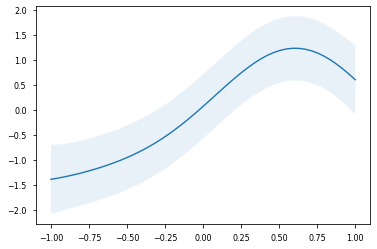

In [ ]:
mu_y, var_y = posterior(params, prior_funcs, X, y, test_X, True, False)

uncertainty = 1.96 * jnp.sqrt(var_y.squeeze())

plt.fill_between(test_X.squeeze(), mu_y.squeeze() + uncertainty, mu_y.squeeze() - uncertainty, alpha=0.1)
plt.plot(test_X.squeeze(), mu_y.squeeze(), label='Mean')

## 5. Loss - Log-Likelihood

### From Scratch

In [ ]:

# @jax.jit
def cholesky_factorization(K, Y):
    
    # cho factor the cholesky 
    L = jax.scipy.linalg.cho_factor(K)

    # weights
    weights = jax.scipy.linalg.cho_solve(L, Y)
    
    return L, weights

def nll_scratch(gp_priors, params, X, Y) -> float:
    
    (mu_func, cov_func) = gp_priors
    
    # ==========================
    # 1. GP PRIOR
    # ==========================
    mu_x, Kxx = gp_prior(params, mu_f=mu_func, cov_f=cov_func , x=X)
    
    # ===========================
    # 2. CHOLESKY FACTORIZATION
    # ===========================    
    (L, lower), alpha = cholesky_factorization(Kxx + ( params['likelihood_noise'] + 1e-5 ) * jnp.eye(Kxx.shape[0]), Y)

    logging.debug(f"Y: {Y.shape},alpha:{alpha.shape}")
    log_likelihood = -0.5 * jnp.einsum("ik,ik->k", Y, alpha)
    log_likelihood -= jnp.sum(jnp.log(jnp.diag(L)))
    log_likelihood -= ( Kxx.shape[0] / 2 ) * jnp.log(2 * jnp.pi)

    return - jnp.sum(log_likelihood)


In [ ]:
# MEAN FUNCTION
mu_f = zero_mean

# COVARIANCE FUNCTION
params = {
    'gamma': 1.0,
    'var_f': 1.0,
    'likelihood_noise': 0.01,
}
cov_f = functools.partial(gram, rbf_kernel)


prior_funcs = (mu_f, cov_f)
# print(X.shape, y.shape, test_X.shape)

nll = nll_scratch(prior_funcs, params, X, y)
print(nll)

54.87834


#### Auto-Batching with VMAP

In [ ]:
nll_scratch_vec = jax.vmap(nll_scratch, in_axes=(None, None, 0, 0))

nll = nll_scratch_vec(prior_funcs, params, X, y[:, None])
print(nll.sum())


42.568897


### Refactor - Built-in Function

It turns out that the jax library already has the `logpdf` for the `multivariate_normal` already implemented. So we can just use that.

In [ ]:
def gp_prior(params, mu_f, cov_f, x):
    return mu_f(x) , cov_f(params, x, x)

def marginal_likelihood(prior_params, params,  Xtrain, Ytrain):
    
    # unpack params
    (mu_func, cov_func) = prior_params
    
    # ==========================
    # 1. GP Prior, mu(), cov(,)
    # ==========================
    mu_x = mu_f(Ytrain)
    logging.debug(f"mu: {mu_x.shape}")
    Kxx = cov_f(params, Xtrain, Xtrain)
    logging.debug(f"Kxx: {Kxx.shape}")
    
    # ===========================
    # 2. GP Likelihood
    # ===========================
    K_gp = Kxx + ( params['likelihood_noise'] + 1e-6 ) * jnp.eye(Kxx.shape[0])
    
    # ===========================
    # 3. Log Probability
    # ===========================
    log_prob = jax.scipy.stats.multivariate_normal.logpdf(x=Ytrain.T, mean=mu_x, cov=K_gp)

    # Negative Marginal log-likelihood
    return -log_prob.sum()
    

#### Digression - Scipy Stats Function

This actually works for multiple scenarios including single sample, multidimensional inputs, multidimensional outputs. 

##### Single Sample

In [ ]:
# Single Sample
X, y, Xtest, ytest = get_data()
test_X = X[0,:]
test_Y = y[0,:]
logging.debug(f"Inputs, X: {test_X.shape}, y: {test_Y.shape}")
prior_funcs = (mu_f, cov_f)

log_prob = marginal_likelihood(prior_funcs, params, test_X, test_Y)

logging.info(f"LogProb: {log_prob}")

INFO:root:LogProb: 1.9503380060195923


##### Multiple Samples

In [ ]:
# Multiple Samples
X, y, Xtest, ytest = get_data()
test_X = X
test_Y = y
nll = marginal_likelihood(prior_funcs, params, test_X, test_Y)
logging.info(f"NLL: {nll}")

INFO:root:NLL: 54.936920166015625


##### Multiple Input Dimensions

In [ ]:
# Multiple Input Dimensions
X, y, Xtest, ytest = get_data()
test_X = jnp.hstack([X,X])
test_Y = y
nll = marginal_likelihood(prior_funcs, params, test_X, test_Y)
logging.info(f"NLL: {nll}")

INFO:root:NLL: 49.61053466796875


##### Multiple Output Dimensions

In [ ]:
# Multiple Output Dimensions
X, y, Xtest, ytest = get_data()
test_X = jnp.hstack([X,X])
test_Y = jnp.hstack([y,y])
nll = marginal_likelihood(prior_funcs, params, test_X, test_Y)
logging.info(f"NLL: {nll}")

INFO:root:NLL: 99.2210693359375


##### Multiple Samples

In [ ]:
logger.setLevel(logging.INFO)
# %timeit _ = nll_scratch(prior_funcs, params, X, y)
%timeit _ = marginal_likelihood(prior_funcs, params, X, y)

10 loops, best of 3: 39.1 ms per loop


## 6. Training

In [ ]:
# Nice Trick for better training of params
def saturate(params):
    return {ikey:softplus(ivalue) for (ikey, ivalue) in params.items()}

In [ ]:
logger.setLevel(logging.INFO)

X, y, Xtest, ytest = get_data(50)


# PRIOR FUNCTIONS (mean, covariance)
mu_f = zero_mean
cov_f = functools.partial(gram, rbf_kernel)
gp_priors = (mu_f, cov_f)

# Kernel, Likelihood parameters
params = {
    'gamma': 2.0,
    # 'length_scale': 1.0,
    # 'var_f': 1.0,
    'likelihood_noise': 1.,
}
# saturate parameters with likelihoods
params = saturate(params)

# LOSS FUNCTION
mll_loss = jax.jit(functools.partial(marginal_likelihood, gp_priors))

# GRADIENT LOSS FUNCTION
dloss = jax.jit(jax.grad(mll_loss))


# STEP FUNCTION
@jax.jit
def step(params, X, y, opt_state):
    # calculate loss
    loss = mll_loss(params, X, y)

    # calculate gradient of loss
    grads = dloss(params, X, y)

    # update optimizer state
    opt_state = opt_update(0, grads, opt_state)

    # update params
    params = get_params(opt_state)

    return params, opt_state, loss

# initialize optimizer
opt_init, opt_update, get_params = optimizers.rmsprop(step_size=1e-2)

# initialize parameters
opt_state = opt_init(params)

# get initial parameters
params = get_params(opt_state)

# TRAINING PARARMETERS
n_epochs = 500
learning_rate = 0.1
losses = list()
postfix = {}

import tqdm

with tqdm.trange(n_epochs) as bar:

    for i in bar:


        
        # 1 step - optimize function
        params, opt_state, value = step(params, X, y, opt_state)




        # update params
        postfix = {}
        for ikey in params.keys():
            postfix[ikey] = f"{jax.nn.softplus(params[ikey]):.2f}"

        # save loss values
        losses.append(value.mean())

        # update progress bar
        postfix["Loss"] = f"{onp.array(losses[-1]):.2f}"
        bar.set_postfix(postfix)
        # saturate params
        params = saturate(params)


        



100%|██████████| 500/500 [00:05<00:00, 84.27it/s, gamma=2.20, likelihood_noise=0.06, Loss=14.18]


{'gamma': 2.1963813668453316, 'likelihood_noise': 0.06418536057067861}

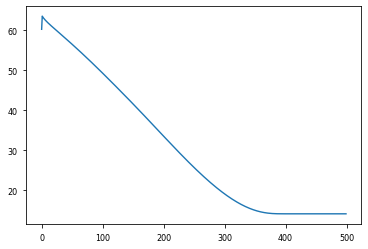

In [ ]:
plt.plot(losses)
params

## 7. Predictions

In [ ]:
# print(X.shape, y.shape, test_X.shape)
logger.setLevel(logging.INFO)

logging.info(f"X:{X.shape}, y:{y.shape}, X*:{Xtest.shape}")
mu_y, cov_y = posterior(params, gp_priors, X, y, Xtest, True, True)
_, var_y = posterior(params, gp_priors, X, y, Xtest, True, False)
logging.info(f"X:{mu_y.shape}, cov:{cov_y.shape}, var:{var_y.shape}")
onp.testing.assert_array_almost_equal(onp.array(jnp.diag(cov_y)), onp.array(var_y), decimal=1e-5)

INFO:root:X:(50, 1), y:(50, 1), X*:(400, 1)
INFO:root:X:(400, 1), cov:(400, 400), var:(400,)


In [ ]:
logger.setLevel(logging.INFO)
%timeit _ = posterior(params, gp_priors, X, y, Xtest, True, True)
%timeit _ = posterior(params, gp_priors, X, y, Xtest, True, False)

100 loops, best of 3: 8.59 ms per loop
100 loops, best of 3: 12.7 ms per loop


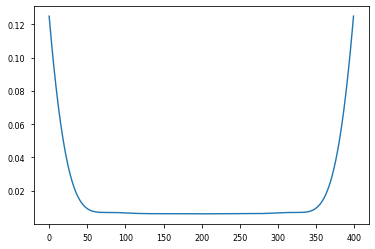

In [ ]:
mu_y, var_y = posterior(params, gp_priors, X, y, Xtest, False, False)
plt.plot(var_y)

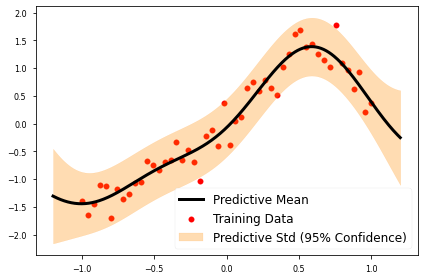

In [ ]:
mu_y, var_y = posterior(params, gp_priors, X, y, Xtest, True, False)

uncertainty = 1.96 * jnp.sqrt(var_y.squeeze())


fig, ax = plt.subplots()
ax.scatter(X, y, c='red', label='Training Data')
plt.plot(Xtest.squeeze(), mu_y.squeeze(), label=r'Predictive Mean', color='black', linewidth=3)
plt.fill_between(
    Xtest.squeeze(), mu_y.squeeze() + uncertainty, mu_y.squeeze() - uncertainty, 
    alpha=0.3,
    color='darkorange',
    label=f"Predictive Std (95% Confidence)"
    )
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()